Tuned parameters: 

learning rate (epsilon) = .00999, learning rate decay per every other epoch = 0.8

Stopping conditions: Deterministic - 3 epochs (3 full SGD sweeps)

Weight initialization: Standard Gaussian with mean = 0 and std = .01

Final training accuracy: 0.99952

Final validation accuracy: 0.9822

Total running time: 18 minutes

Kaggle score: 0.97680

Plots of total training loss and classification accuracy on training set vs. iteration:
(two plots). See plots below.

[[-0.13336922 -0.13336922 -0.13336922 ..., -0.13336922 -0.13336922
  -0.13336922]
 [-0.13336922 -0.13336922 -0.13336922 ..., -0.13336922 -0.13336922
  -0.13336922]
 [-0.13336922 -0.13336922 -0.13336922 ..., -0.13336922 -0.13336922
  -0.13336922]
 ..., 
 [-0.13336922 -0.13336922 -0.13336922 ..., -0.13336922 -0.13336922
  -0.13336922]
 [-0.13336922 -0.13336922 -0.13336922 ..., -0.13336922 -0.13336922
  -0.13336922]
 [-0.13336922 -0.13336922 -0.13336922 ..., -0.13336922 -0.13336922
  -0.13336922]]
TRAIN ERROR: 0.92224, VALIDATION ERROR: 0.9268
Trial with epsilon=0.00999. Time elapsed: 0.0 minutes, 1.24991202354 seconds.
[ITERATION] 50000 J = [[ 0.00035864]]EPOCH: 0, TRAIN ERROR: 0.03462, VALIDATION ERROR: 0.0446
Trial with epsilon=0.00999. Time elapsed: 3.0 minutes, 18.8324551582 seconds.
[ITERATION] 50000 J = [[ 0.32953868]]EPOCH: 1, TRAIN ERROR: 0.01874, VALIDATION ERROR: 0.0322
Trial with epsilon=0.007992. Time elapsed: 6.0 minutes, 19.6030380726 seconds.
[ITERATION] 50000 J = [[ 0.000

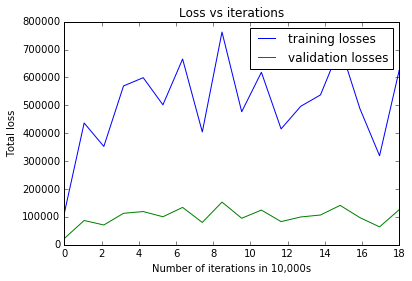

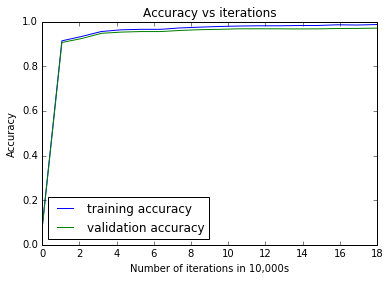

In [18]:
import csv
from mnist import MNIST
from sys import stdout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as metrics
import time
NUM_CLASSES = 10

def one_hot(labels_train):
    '''Convert categorical labels 0,1,2,....9 to standard basis vectors in R^{10} '''
    return np.eye(NUM_CLASSES)[labels_train]

def shuffle(Xtrain, ytrain):
    stacked = np.column_stack((Xtrain,ytrain))
    np.random.shuffle(stacked)
    return stacked[:,:Xtrain.shape[1]], stacked[:,Xtrain.shape[1]]
    
# oh no I cannot hog D:
# data augmentations:
def rotation(X):
    return np.roll(X, 1, axis=1)

def shear(X):
    for i in range(X.shape[1]):
        X[:,i] = np.roll(x[:,i], i)

def random_noise(X):
    noise = np.random.normal(0, .01, X.shape)
    return X + noise

def load_dataset():
    mndata = MNIST('./data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, _ = map(np.array, mndata.load_testing())
    X_train = (X_train - np.mean(X_train)) / 255 #np.std(X_train) # or / 255
    X_test = (X_test - np.mean(X_test)) / 255
    X_train, labels_train = shuffle(X_train, labels_train.astype(float))
    X_validate = X_train[50000:X_train.shape[0]]
    labels_validate = labels_train[50000:labels_train.shape[0]]
    
    y_train = one_hot(labels_train[:50000].astype(int))
    y_v = one_hot(labels_validate.astype(int))
    print X_test
    return X_train[:50000], y_train, labels_train[:50000], X_test, X_validate, y_v, labels_validate


def stackones(A, axis=0):
    assert axis in [0, 1]
    if axis == 1:
        return np.hstack((A, np.ones((A.shape[0], 1))))
    return np.vstack((A, np.ones((1, A.shape[1]))))

def softmax(z):
    #Apply softmax activation function
    #use exp-normalize trick
    e_z = np.exp(z - np.max(z))
    return e_z / e_z.sum()

def relu(z):
    return np.maximum(0,z)

def relu_prime(z):
    return 1. * (z > 0)
    #return np.log((1. * (z > 0))+1e-10)


class Neural_Network(object):
    def __init__(self, X, X_v, y, y_v, l, l_v, epsilon=1e-3, epochs=10, reg=0.1, log_lower_bound=.0001, W=None, V=None):        
        #Define Hyperparameters
        self.n_in = X.shape[1]
        self.n_out = y.shape[1]
        self.n_hid = 200
        self.sigma = .01
        #Regularization Parameter:
        self.reg = 0
        #learning rate
        self.epsilon = epsilon # or is it 1e-2 .01
        # learning rate decay. usually .5 or .9
        self.decay = .8
        self.log_lower_bound = log_lower_bound
        self.t = time.time()
        self.training_accuracy = []
        self.validation_accuracy = []
        self.running_time = []
        self.training_losses = []
        self.validation_losses = []
        self.epochs = epochs
        #Define Data
        self.X = X
        self.X_v = X_v
        self.y = y
        self.y_v = y_v 
        self.l = l
        self.l_v = l_v
        #Weights (parameters)
        # to initialize as gaussian with mean = 0, variance < 1.
        if W == None:
            self.W = np.random.normal(0, self.sigma, (self.n_out, self.n_hid + 1))
        else:
            self.W = W
        if V == None:
            self.V = np.random.normal(0, self.sigma, (self.n_hid, self.n_in + 1))
        else:
            self.V = V
    
    def forward(self, X):
        #print(X.shape)
        self.inp = stackones(X, axis=1)
        self.z1 = self.inp.dot(self.V.T)
        self.a1 = relu(self.z1) # (1, 200)
        self.hid = stackones(self.a1, axis=1)
        self.z2 = self.hid.dot(self.W.T)
        self.out = softmax(self.z2)
        return self.out

    def predict(self, X):
        inp = stackones(X, axis=1)
        z1 = inp.dot(self.V.T)
        a1 = relu(z1)
        hid = stackones(a1, axis=1)
        z2 = hid.dot(self.W.T)
        out = softmax(z2)
        yHat = np.argmax(out, 1)
        return yHat

    def cross_entropy_loss(self, X, y):
        #Compute loss for given X,y, use weights already stored in class.
        # To lower bound the values that you take the log of, since you cannot compute log0
        #self.z = self.forward_pass(X).clip(1e-10, 1-1e-10)
        y = np.matrix(y)
        self.j = -y.dot(np.log(self.out.T+1e-10))
        return self.j

    def loss_prime(self, X, y):
        #Compute derivative with respect to W and V for a given X and y:
        # (1, 200)
        self.h = relu(self.inp.dot(self.V.T)) # hidden layer
        self.h = stackones(self.h, axis=1)
        
        self.deltaW = self.out-y # the delta with respect to W
        #print self.deltaW.shape
        # n_out by n_hid+1
        self.dJdW = self.deltaW.reshape((10,1)).dot(self.h)
        self.dJdV = 0
        
        X = np.matrix(X) 
        X = stackones(X, axis=1) # (1, 785)
        #print self.deltaW.shape
        #print self.W.shape
        self.dJdh = self.W.T.dot(self.deltaW.T)
        self.deltaV = np.multiply(self.dJdh[:self.dJdh.shape[0]-1,:], relu_prime(self.V.dot(X.T))) # (200,1)
        self.dJdV = self.deltaV.dot(X) 
        
        return self.dJdW, self.dJdV

    def backprop(self, V, W, X, y, epsilon):
        self.loss_prime(X, y)
        return V-epsilon*self.dJdV, W-epsilon*self.dJdW
    
    # train with stochastic gradient descent
    def train(self):
        yHat = self.predict(self.X)
        train_acc = metrics.accuracy_score(self.l, yHat)
        #self.training_accuracy.append(train_acc)
        
        yHat_v = self.predict(self.X_v)
        val_acc = metrics.accuracy_score(self.l_v, yHat_v)
        #self.validation_accuracy.append(val_acc)
        
        #self.training_losses.append(np.sum(self.cross_entropy_loss(self.X, self.y)))
        #self.validation_losses.append(np.sum(self.cross_entropy_loss(self.X_v, self.y_v)))
        
        m, s = divmod(time.time() - self.t, 60)
        self.running_time.append(m)
        print("TRAIN ERROR: {}, VALIDATION ERROR: {}".format(1-train_acc, 1-val_acc))
        print("Trial with epsilon={}. Time elapsed: {} minutes, {} seconds.".format(self.epsilon, m, s))
        
        for i in range(self.epochs):
            indices = np.random.permutation(xrange(self.X.shape[0]))
            
            for j in range(self.X.shape[0]):
                y = self.y[indices[j], :]
                X = self.X[indices[j], :].reshape((1, self.X.shape[1]))
                out = self.forward(X)
                self.V, self.W = self.backprop(self.V, self.W, X, y, self.epsilon)
                self.j = self.cross_entropy_loss(X,y)
                stdout.write("\r[ITERATION] {} J = {}".format(j + 1, self.j))
                stdout.flush()
                
                if j%10000 == 0 or j == self.X.shape[0]-1:
                    self.training_losses.append(np.sum(self.cross_entropy_loss(self.X, self.y)))
                    self.validation_losses.append(np.sum(self.cross_entropy_loss(self.X_v, self.y_v)))
                   
                    yHat = self.predict(self.X)
                    train_acc = metrics.accuracy_score(self.l, yHat)
                    self.training_accuracy.append(train_acc)

                    yHat_v = self.predict(self.X_v)
                    val_acc = metrics.accuracy_score(self.l_v, yHat_v)
                    self.validation_accuracy.append(val_acc)
                    
            train_acc = self.training_accuracy[len(self.training_accuracy)-1]
            val_acc = self.validation_accuracy[len(self.validation_accuracy)-1]
            m, s = divmod(time.time() - self.t, 60)
            self.running_time.append(m)
            print("EPOCH: {}, TRAIN ERROR: {}, VALIDATION ERROR: {}".format(i, 1-train_acc, 1-val_acc))
            print("Trial with epsilon={}. Time elapsed: {} minutes, {} seconds.".format(self.epsilon, m, s))
            
            if i%2 == 0:
                self.epsilon = self.decay*self.epsilon
                
        print "D O N E"
        return self

def kaggle(epsilon, epochs):
    X_train, y_train, labels_train, X_test, X_validate, y_validate, labels_validate = load_dataset()
    nn = Neural_Network(X_train, X_validate, y_train, y_validate, labels_train, labels_validate, epsilon, epochs)
    nn.train()

    X_train = random_noise(X_train)
    X_validate = random_noise(X_validate)
    nnaug = Neural_Network(X_train, X_validate, y_train, y_validate, labels_train, labels_validate, epsilon, epochs, 0.1, .0001, nn.W, nn.V)
    nnaug.train()

    pred = nn.predict(X_test)
    pred_labels_test = []
    for label in pred:
        pred_labels_test.append(np.asscalar(label))

    with open('kaggle_epsilon'+str(epsilon)+'.csv', 'w') as fp:
        a = csv.writer(fp, delimiter=',')
        a.writerow(["Id","Category"])
        data = [[i+1, pred_labels_test[i]] for i in range(len(pred_labels_test))]
        a.writerows(data)

def linear_sweep():
    # linear sweep of all the epsilons
    epsilon = 1e-2
    for i in range(0,1000):
        print ("EPSILON: {}".format(epsilon-i*1e-5))
        nn = Neural_Network(X_train, X_validate, y_train, y_validate, labels_train, labels_validate, epsilon-i*1e-5)
        nn.train()

def writeup(epsilon=.00999,epochs=3):
    X_train, y_train, labels_train, X_test, X_validate, y_validate, labels_validate = load_dataset()
    nn = Neural_Network(X_train, X_validate, y_train, y_validate, labels_train, labels_validate, epsilon, epochs)
    nn.train()
    plt.figure()
    x = np.linspace(0, len(nn.training_losses), len(nn.training_losses))
    plt.plot(x, np.array(nn.training_losses), label='training losses')
    plt.plot(x, np.array(nn.validation_losses), label='validation losses')
    plt.legend(loc='best')
    plt.title('Loss vs iterations')
    plt.xlabel('Number of iterations in 10,000s')
    plt.ylabel('Total loss')
    plt.show()

    plt.figure()
    x = np.linspace(0, len(nn.training_accuracy), len(nn.training_accuracy))
    plt.plot(x, np.array(nn.training_accuracy), label='training accuracy')
    plt.plot(x, np.array(nn.validation_accuracy), label='validation accuracy')
    plt.legend(loc='best')
    plt.title('Accuracy vs iterations')
    plt.xlabel('Number of iterations in 10,000s')
    plt.ylabel('Accuracy')
    plt.show()

#kaggle(0.00999, 3)
writeup()  